<a href="https://colab.research.google.com/github/agneya23/Face-Mask-Segmentation/blob/main/Face_Mask_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torchvision
import cv2
from google.colab.patches import cv2_imshow
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision import models

%matplotlib inline

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [3]:
# Prepare file paths
dir_train_imgs = r'/content/drive/MyDrive/AI_ML/Projects/Face Mask Segmentation/data/images/train/'
dir_test_imgs = r'/content/drive/MyDrive/AI_ML/Projects/Face Mask Segmentation/data/images/test/'

dir_train_masks = r'/content/drive/MyDrive/AI_ML/Projects/Face Mask Segmentation/data/masks/train/'
dir_test_masks = r'/content/drive/MyDrive/AI_ML/Projects/Face Mask Segmentation/data/masks/test/'

In [4]:
# Prepare list of file names for each file path
images_train_filenames = os.listdir(dir_train_imgs)
images_test_filenames = os.listdir(dir_test_imgs)

masks_train_filenames = os.listdir(dir_train_masks)
masks_test_filenames = os.listdir(dir_test_masks)

images_train_filenames.sort()
images_test_filenames.sort()
masks_train_filenames.sort()
masks_test_filenames.sort()

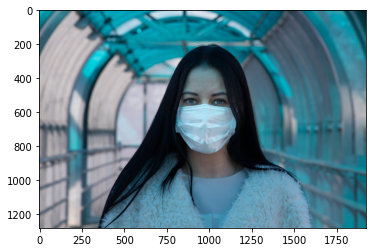

In [5]:
# Sample Input Image
img = cv2.imread(dir_train_imgs + images_train_filenames[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

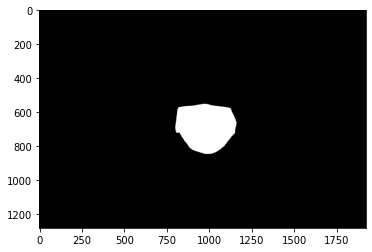

In [7]:
# Corresponding Segmentation Mask
img = cv2.imread(dir_train_masks + masks_train_filenames[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

In [ ]:
# Prepare file save paths
save_train_imgs = r'/content/drive/MyDrive/AI_ML/Projects/Face Mask Segmentation/preprocessed_data/images/train/'
save_test_imgs = r'/content/drive/MyDrive/AI_ML/Projects/Face Mask Segmentation/preprocessed_data/images/test/'

save_train_masks = r'/content/drive/MyDrive/AI_ML/Projects/Face Mask Segmentation/preprocessed_data/masks/train/'
save_test_masks = r'/content/drive/MyDrive/AI_ML/Projects/Face Mask Segmentation/preprocessed_data/masks/test/'

In [ ]:
# Run once to save detected faces then comment out
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

i = 1
for filename in images_train_filenames:
    path_img = os.path.join(dir_train_imgs, filename)
    path_mask = os.path.join(dir_train_masks, filename[:-3] + 'png')
    img = cv2.imread(path_img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    for (x,y,w,h) in faces:
        crop_img = img[y:y+h, x:x+w, :]
        crop_mask = mask[y:y+h, x:x+w]
        cv2.imwrite(save_train_imgs + str(i) + '.jpg', crop_img)
        cv2.imwrite(save_train_masks + str(i) + '.jpg', crop_mask)
        i += 1

i = 1
for filename in images_test_filenames:
    path_img = os.path.join(dir_test_imgs, filename)
    path_mask = os.path.join(dir_test_masks, filename[:-3] + 'png')
    img = cv2.imread(path_img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
    for (x,y,w,h) in faces:
        crop_img = img[y:y+h, x:x+w, :]
        crop_mask = mask[y:y+h, x:x+w]
        cv2.imwrite(save_test_imgs + str(i) + '.jpg', crop_img)
        cv2.imwrite(save_test_masks + str(i) + '.jpg', crop_mask)
        i += 1

In [ ]:
# Transformations to be applied
transforms_ = torchvision.transforms.Compose([torchvision.transforms.Resize((256, 256))])

In [ ]:
# Custom Dataset Class
class Image_Dataset(torch.utils.data.Dataset):

    def __init__(self, imgs_path, masks_path, transforms):
        self.transform = transforms
        self.imgs_path = imgs_path
        self.masks_path = masks_path
        self.hazy_lst = sorted(os.listdir(self.imgs_path))
        self.mask_lst = sorted(os.listdir(self.masks_path))
        self.length = len(self.hazy_lst)
        self.img, self.mask = [], []
        for filename in self.hazy_lst:
            path = os.path.join(self.imgs_path, filename)
            img = torchvision.io.read_image(path, mode=torchvision.io.ImageReadMode.RGB)/255
            self.img.append(img)
        for filename in self.mask_lst:
            path = os.path.join(self.masks_path, filename)
            img = torchvision.io.read_image(path, mode=torchvision.io.ImageReadMode.GRAY)/255
            self.mask.append(img)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        sample = {'img': self.transform(self.img[idx]), 'mask': self.transform(self.mask[idx])}
        return sample

In [ ]:
# Train and Test Datasets and Dataloaders
train_dataset = Image_Dataset(save_train_imgs, save_train_masks, transforms_)
test_dataset = Image_Dataset(save_test_imgs, save_test_masks, transforms_)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
# Initialize model, loss and optimizer
weights = DeepLabV3_ResNet50_Weights
model_backbone = deeplabv3_resnet50(weights=weights)
last_layer = torch.nn.Sequential(torch.nn.Conv2d(21, 1, 3, padding='same'),
                                 torch.nn.Sigmoid())
model_backbone.to(device)
last_layer.to(device)
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam([*model_backbone.parameters(), *last_layer.parameters()], lr=1e-6)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Train the model
max_epoch = 50
model_backbone.train()

for epoch in range(1, max_epoch+1):
    total_train_loss = 0
    for sample in train_dataloader:
        train_image, train_mask = sample['img'], sample['mask']
        train_image = train_image.to(torch.float32).to(device)
        train_mask = train_mask.to(torch.float32).to(device)
        output = model_backbone(train_image)['out']
        output = last_layer(output)
        train_loss = loss(output, train_mask)
        total_train_loss += train_loss
        optimizer.zero_grad()
        train_loss.backward(retain_graph=False)
        optimizer.step()
    
    total_train_loss /= len(train_dataset)

    if epoch == 1 or epoch % 5 == 0:
        print('The value of train_loss at epoch {}: {}'.format(epoch, total_train_loss))

The value of train_loss at epoch 1: 0.32236742973327637
The value of train_loss at epoch 5: 0.17685604095458984
The value of train_loss at epoch 10: 0.13329766690731049
The value of train_loss at epoch 15: 0.11080919951200485
The value of train_loss at epoch 20: 0.09693637490272522
The value of train_loss at epoch 25: 0.08322567492723465
The value of train_loss at epoch 30: 0.07566574960947037
The value of train_loss at epoch 35: 0.06804423034191132
The value of train_loss at epoch 40: 0.06420914083719254
The value of train_loss at epoch 45: 0.05962003767490387
The value of train_loss at epoch 50: 0.055896513164043427


In [ ]:
# Make predictions on test data
predictions = []
model_backbone.eval()
for sample in test_dataloader:
    test_image = sample['img']
    test_image = test_image.to(torch.float32).to(device)
    output = model_backbone(test_image)['out']
    output = last_layer(output)
    predictions.append(output.detach().cpu())

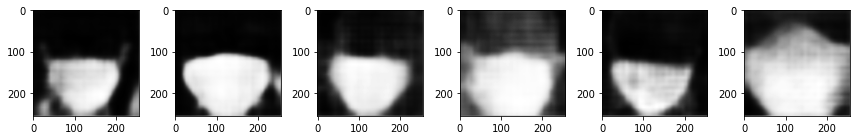

In [ ]:
# Display outputs generated by model
pred_lst = []
for prediction in predictions:
    pred_lst.append(prediction[0].squeeze())
    pred_lst.append(prediction[1].squeeze())

plt.rcParams["figure.figsize"] = [12.00, 3.00]
plt.rcParams["figure.autolayout"] = True
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(pred_lst[i], cmap='gray')

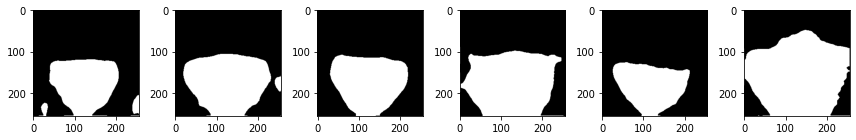

In [ ]:
# Predictions after step function
pred_lst_step = []
for img in pred_lst:
    img[img <= 0.5] = 0
    img[img > 0.5] = 1
    pred_lst_step.append(img)

plt.rcParams["figure.figsize"] = [12.00, 3.00]
plt.rcParams["figure.autolayout"] = True
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(pred_lst_step[i], cmap='gray')

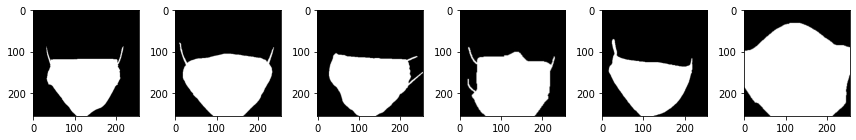

In [ ]:
# Corresponding ground truth masks for the above predictions
gt = []
for sample in test_dataloader:
    img = sample['mask'][0]
    gt.append(img.squeeze())
    img = sample['mask'][1]
    gt.append(img.squeeze())

plt.rcParams["figure.figsize"] = [12.00, 3.00]
plt.rcParams["figure.autolayout"] = True
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(gt[i], cmap='gray')

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-6
    intersection = (outputs & labels).float().sum()
    union = (outputs | labels).float().sum()
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    return thresholded

IOU = 0
for pred_stp, mask in zip(pred_lst_step, gt):
    IOU += iou_pytorch(pred_stp.to(torch.int), mask.to(torch.int))
print("IOU: {}".format(IOU/(2*len(test_dataloader))))

IOU: 0.7833333015441895
